In [1]:
using Revise
using ProgressMeter
using Plots
using Statistics, RollingFunctions
includet("../experiment/cycleworld_rgtd.jl")

┌ Warning: `@add_arg_table` is deprecated, use `@add_arg_table!` instead
└ @ ArgParse In[1]:5


In [2]:
function run_experiment(args, num_runs)
    results = Array{Dict}(undef, num_runs)

    prg_bar = Progress(num_runs)

    Threads.@threads for run in 1:num_runs
        t_args = copy(args)
        t_args["seed"] = run + 1029
        ret = CycleWorldRGTDExperiment.main_experiment(t_args; working=true, progress=false)
        results[run] = ret
        next!(prg_bar)
    end
    results
end    

run_experiment (generic function with 1 method)

In [3]:
num_runs = 50

50

In [4]:
args = Dict{String,Any}(
        "seed" => 1,
        "steps" => 100000,
        "chain" => 6,
        "opt" => "Descent",
        "truncation" => 3,

        "alpha" => 0.1,

        "lu" => "RGTD",
        "rgtd-alpha" => 0.2,
        "rgtd-beta" => 0.01,
        
        "act" => "sigmoid",
        "horde" => "chain",
        "gamma" => 0.9,

        "save_dir" => "cycleworld_rgtd")

results_chain_01 = run_experiment(args, num_runs);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:30


In [5]:
args = Dict{String,Any}(
        "seed" => 1,
        "steps" => 100000,
        "chain" => 6,
        "opt" => "Descent",
        "truncation" => 3,

        "alpha" => 0.1,

        "lu" => "RGTD",
        "rgtd-alpha" => 0.2,
        "rgtd-beta" => 0.001,
        
        "act" => "sigmoid",
        "horde" => "chain",
        "gamma" => 0.95,

        "save_dir" => "cycleworld_rgtd")

results_chain_001 = run_experiment(args, num_runs);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:30


In [6]:
args = Dict{String,Any}(
        "seed" => 1,
        "steps" => 100000,
        "chain" => 6,
        "opt" => "Descent",
        "truncation" => 3,

        "alpha" => 0.1,

        "lu" => "RGTD",
        "rgtd-alpha" => 0.2,
        "rgtd-beta" => 0.001,
#         "scale"=>0.00005f0
        
        "act" => "sigmoid",
        "horde" => "gamma_chain",
        "gamma" => 0.9,

        "save_dir" => "cycleworld_rgtd")

results_gamma_chain = run_experiment(args, num_runs);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:57


In [7]:
args = Dict{String,Any}(
        "seed" => 1,
        "steps" => 100000,
        "chain" => 6,
        "opt" => "Descent",
        "truncation" => 3,

        "alpha" => 0.1,

        "lu" => "RGTD",
        "rgtd-alpha" => 0.2,
        "rgtd-beta" => 0.01,
#         "scale"=>0.00005f0
        
        "act" => "sigmoid",
        "horde" => "gamma_chain",
        "gamma" => 0.9,

        "save_dir" => "cycleworld_rgtd")

results_gamma_chain_01 = run_experiment(args, num_runs);

TaskFailedException: TaskFailedException:
TypeError: in <:, expected Type, got GVFN.GradientGVFN{GVFN.Horde{GVFN.GVF{C,D,GVFN.NullPolicy} where D<:GVFN.AbstractDiscount where C<:GVFN.AbstractCumulant},typeof(GVFN.sigmoid)}
Stacktrace:
 [1] GVFN.RGTDAgent(::GVFN.Horde{GVFN.GVF{GVFN.FeatureCumulant,GVFN.ConstantDiscount{Float64},GVFN.NullPolicy}}, ::GVFN.GradientGVFN{GVFN.Horde{GVFN.GVF{C,D,GVFN.NullPolicy} where D<:GVFN.AbstractDiscount where C<:GVFN.AbstractCumulant},typeof(GVFN.sigmoid)}, ::GVFN.SingleLayer{typeof(identity),GVFN.var"#7#8",Array{Float32,2},Array{Float32,1}}, ::GVFN.RGTD, ::Flux.Optimise.Descent, ::Int64, ::Function, ::Int64, ::GVFN.RandomActingPolicy{Float64}) at /Users/Matt/Documents/Research/projects/GVFN/src/agent/RGTDAgent.jl:36
 [2] construct_agent(::Dict{String,Any}, ::Random.MersenneTwister) at /Users/Matt/Documents/Research/projects/GVFN/experiment/cycleworld_rgtd.jl:101
 [3] #main_experiment#5(::Bool, ::Bool, ::Bool, ::typeof(Main.CycleWorldRGTDExperiment.main_experiment), ::Dict{String,Any}) at /Users/Matt/Documents/Research/projects/GVFN/experiment/cycleworld_rgtd.jl:134
 [4] #main_experiment at ./none:0 [inlined]
 [5] macro expansion at ./In[2]:9 [inlined]
 [6] (::var"#89#threadsfor_fun#3"{Dict{String,Any},Array{Dict,1},Progress,UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:61
 [7] (::var"#89#threadsfor_fun#3"{Dict{String,Any},Array{Dict,1},Progress,UnitRange{Int64}})() at ./threadingconstructs.jl:28

In [8]:
function plot_results(results_arr; kwargs...)    
    clean_res = Array{Float32}[]
    for i in 1:num_runs
        push!(clean_res, rollmean(abs.(results_arr[i]["out_err_strg"]), 100)[1:100:end])
    end
    plot(mean(clean_res), ribbon = std(clean_res)./sqrt(num_runs); kwargs...)
end

function plot_results(results_arrs::Array{<:AbstractArray, 1}; kwargs...)
    
    clean_res_all = Tuple{Array{Float32}, Array{Float32}}[]
    for results_arr in results_arrs
        clean_res = Array{Float32}[]
        for i in 1:num_runs
            push!(clean_res, rollmean(abs.(results_arr[i]["out_err_strg"]), 100)[1:100:end])
        end
        push!(clean_res_all, (mean(clean_res), std(clean_res)./sqrt(num_runs)))
    end
    plt = plot(clean_res_all[1][1], ribbon = clean_res_all[1][2]; kwargs...)
    for i in 2:length(results_arrs)
        plot!(plt, clean_res_all[i][1], ribbon = clean_res_all[i][2]; kwargs...)
    end
    plt
end

function plot_all_curves(results_arr; kwargs...)
    clean_res = Array{Float32}[]
    for i in 1:num_runs
        push!(clean_res, rollmean(abs.(results_arr[i]["out_err_strg"]), 100)[1:100:end])
    end
#     plot(mean(clean_res), ribbon = std(clean_res)./sqrt(num_runs))
    plot(clean_res; legend=nothing, kwargs...)
end

function plot_a_curve(results_arr, idx; kwargs...)
    clean_res = Array{Float32}[]
    for i in idx
        push!(clean_res, rollmean(abs.(results_arr[i]["out_err_strg"]), 100)[1:100:end])
    end
#     plot(mean(clean_res), ribbon = std(clean_res)./sqrt(num_runs))
    plot(clean_res; legend=nothing, kwargs...)
end

function plot_all_curves_grid(results_arr; kwargs...)
    plts = []
    for i in 1:length(results_arr)
        push!(plts, plot_a_curve(results_arr, i))
    end
    plot(plts...; xaxis=nothing, yaxis=nothing, kwargs...)
end




plot_all_curves_grid (generic function with 1 method)

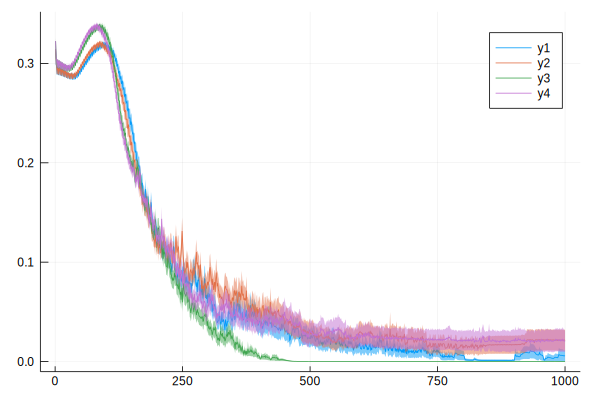

In [32]:
# cur_arr = results_chain_001
plt1 = plot_results([results_chain_001, results_chain_01, results_gamma_chain, results_gamma_chain_01])
# plt2 = plot_all_curves(cur_arr)
# plt2 = plot_a_curve(cur_arr, 10)

# plot(plt1, plt2, size=(1000, 300))


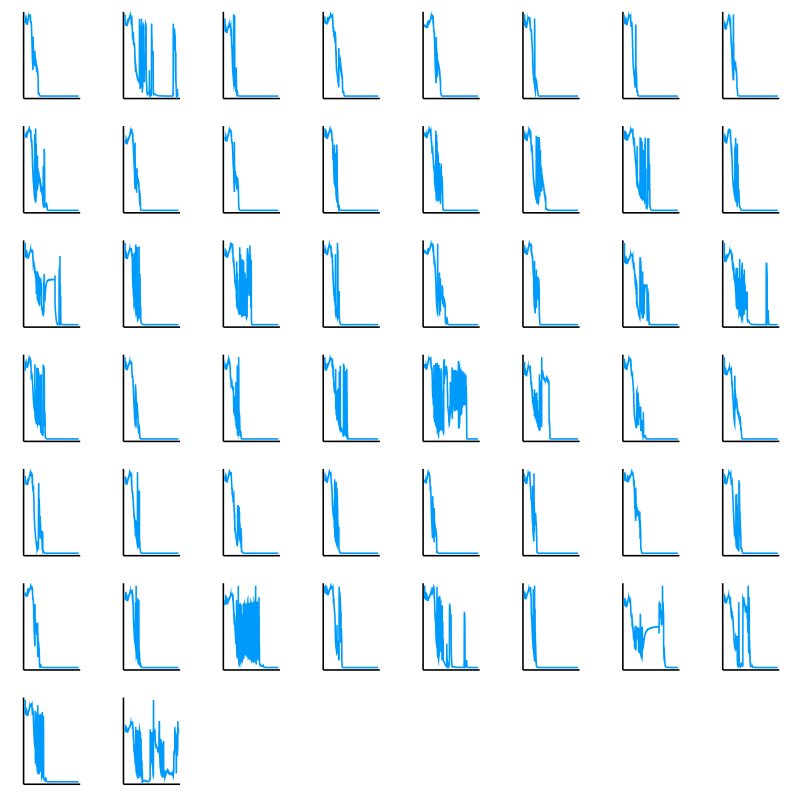

In [33]:

# size(results_chain_001)
plot_all_curves_grid(results_chain_001, size=(800, 800), fmt=:png)
# plot_a_curve(results_chain_001, 1)

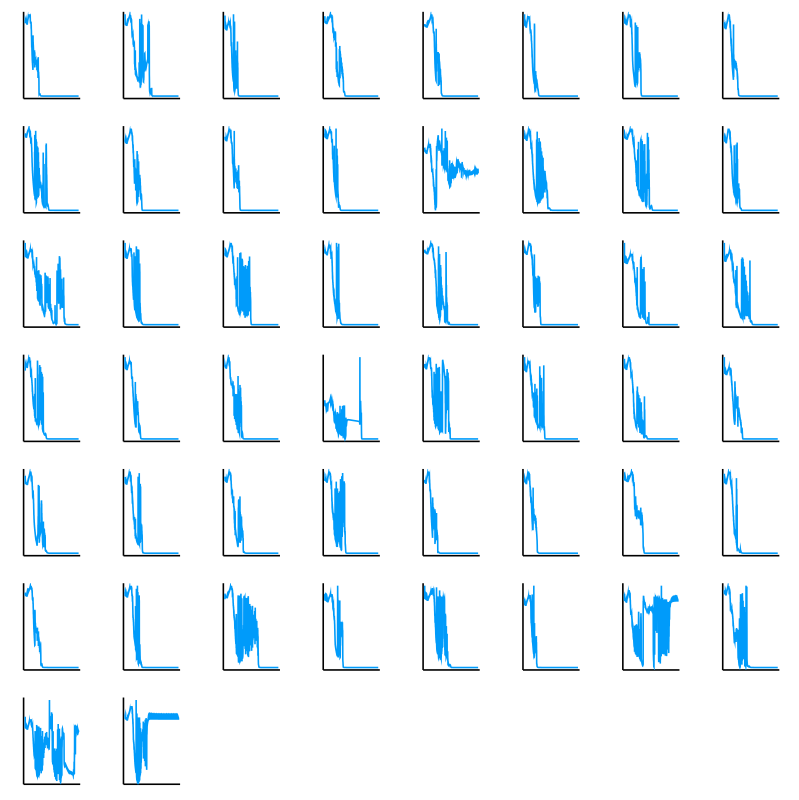

In [34]:
plot_all_curves_grid(results_chain_01, size=(800, 800), fmt=:png)

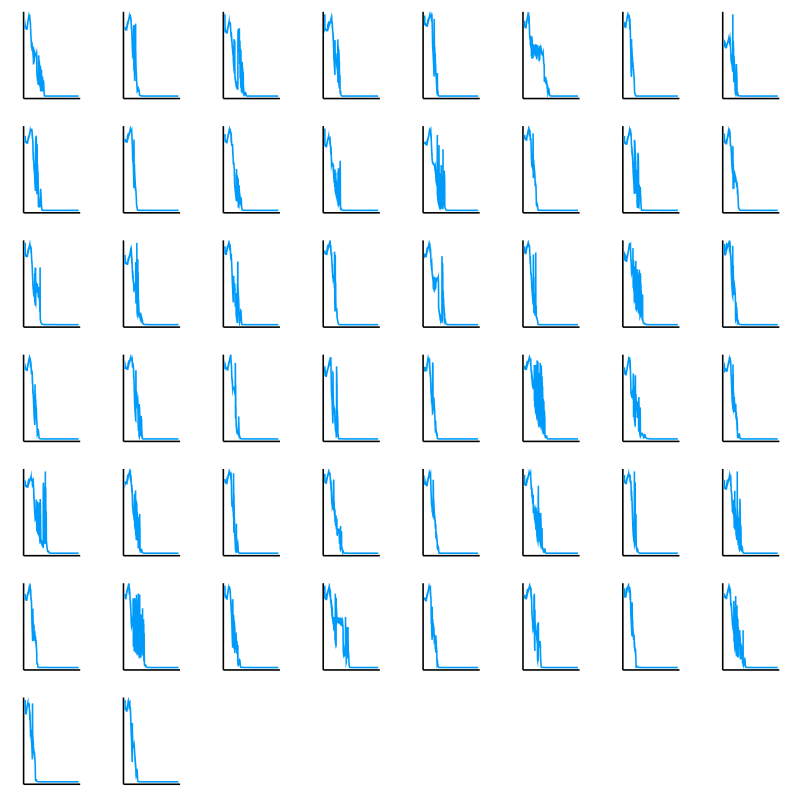

In [35]:
plot_all_curves_grid(results_gamma_chain, size=(800, 800), fmt=:png)

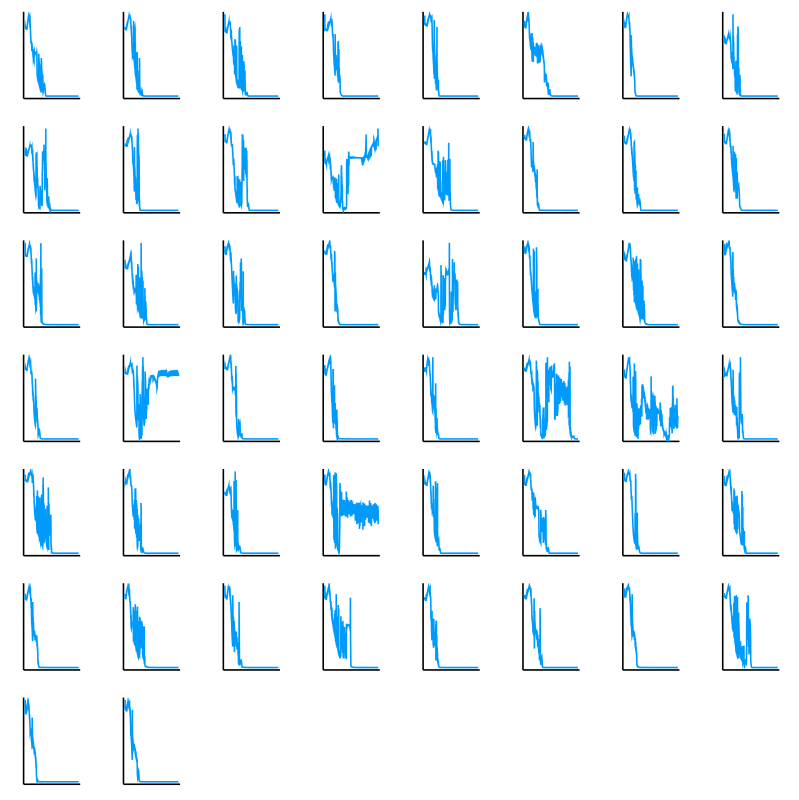

In [36]:
plot_all_curves_grid(results_gamma_chain_01, size=(800, 800), fmt=:png)